In [1]:
# Cell 1 - Setup & imports
import os
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import inspect
import zipfile

# If seaborn or scipy aren't installed, uncomment and run the following once:
# !{sys.executable} -m pip install seaborn scipy

plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 12
sns.set(style="whitegrid", rc={"figure.figsize": (12,6)})

# Change this path if needed
csv_path = r'/Users/utkarshbmathur/Downloads/Amazon Sale Report(in).csv'
assert os.path.exists(csv_path), f"CSV not found at {csv_path}. Please correct the path."
out_dir = Path.cwd() / "assignment_outputs"
out_dir.mkdir(parents=True, exist_ok=True)
print("Input CSV:", csv_path)
print("Outputs folder:", out_dir)


Input CSV: /Users/utkarshbmathur/Downloads/Amazon Sale Report(in).csv
Outputs folder: /Users/utkarshbmathur/Blend_All_Projects/assignment_outputs


In [3]:
# Cell 2 - SalesAnalyzer class
from typing import Optional, List, Dict

class SalesAnalyzer:
    """
    SalesAnalyzer: encapsulates loading, cleaning, KPI calculation, plotting, and saving.
    Usage:
      an = SalesAnalyzer(path_to_csv)
      an.preview()
      an.run_all()  # runs cleaning, KPIs, saves cleaned CSV
      an.plot_all() # creates & saves plots
    """
    def __init__(self, path: str):
        self.path = path
        self.df: pd.DataFrame = pd.DataFrame()
        self.kpis: Dict[str, float] = {}
        self.load_data()
    
    # ---------- Loading ----------
    def load_data(self, **kwargs):
        # be robust to encodings / separators
        try:
            self.df = pd.read_csv(self.path, low_memory=False, **kwargs)
        except Exception as e:
            try:
                self.df = pd.read_csv(self.path, encoding='latin1', low_memory=False, **kwargs)
            except Exception:
                # fallback to Excel
                self.df = pd.read_excel(self.path, engine='openpyxl')
        print("Loaded dataframe shape:", self.df.shape)
    
    # ---------- Utilities ----------
    def preview(self, n=5):
        display(self.df.head(n))
        print(self.df.info())
        print("\nMissing values per column:")
        print(self.df.isna().sum().sort_values(ascending=False).head(20))
    
    def _standardize_columns(self):
        # make lowercase, strip spaces, replace multiple spaces, replace special chars
        def norm(c):
            c = str(c).strip()
            c = " ".join(c.split())
            c = c.lower()
            c = c.replace("(", "").replace(")", "")
            c = c.replace("-", " ").replace("/", " ").replace(".", " ")
            c = c.replace("  ", " ")
            c = c.replace(" ", "_")
            return c
        newcols = {c: norm(c) for c in self.df.columns}
        self.df.rename(columns=newcols, inplace=True)
    
    def _find_col(self, candidates: List[str]) -> Optional[str]:
        # return first matching column name in df (in normalized form)
        cols = list(self.df.columns)
        for cand in candidates:
            cand_norm = cand.lower().replace(" ", "_")
            for c in cols:
                if cand_norm == c:
                    return c
        # try substring
        for cand in candidates:
            for c in cols:
                if cand.lower() in c:
                    return c
        return None
    
    # ---------- Type conversions & cleaning ----------
    def convert_dates(self, candidates=['order_date','date','transaction_date','orderdate']):
        col = self._find_col(candidates)
        if col:
            # try common dayfirst formats too
            self.df[col] = pd.to_datetime(self.df[col], errors='coerce', dayfirst=False)
            # if many NaT and format might be dd/mm/yyyy try dayfirst True
            if self.df[col].isna().mean() > 0.4:
                self.df[col] = pd.to_datetime(self.df[col], errors='coerce', dayfirst=True)
            # standard rename
            if col != 'order_date':
                self.df.rename(columns={col: 'order_date'}, inplace=True)
            print("Date column set to 'order_date'")
        else:
            print("No obvious date column found. Check column names:", list(self.df.columns)[:30])
    
    def convert_numerics(self):
        # attempt to find common numeric columns
        qty = self._find_col(['quantity','qty','units'])
        price = self._find_col(['unit_price','unitprice','price','selling_price','mrp'])
        sales = self._find_col(['sales','revenue','total','amount','order_value','order_total'])
        profit = self._find_col(['profit','gross_profit','net_profit'])
        
        # helper to clean numeric columns
        def clean_num(col):
            self.df[col] = (self.df[col]
                             .astype(str)
                             .str.replace(r'[^0-9\.\-]', '', regex=True)
                             .replace('', np.nan)
                             .astype(float))
        
        for col in [qty, price, sales, profit]:
            if col:
                try:
                    clean_num(col)
                    print("Cleaned numeric:", col)
                except Exception as e:
                    print("Failed numeric cleaning for:", col, e)
        
        # unify names
        if sales and sales != 'sales':
            self.df.rename(columns={sales: 'sales'}, inplace=True)
        if profit and profit != 'profit':
            self.df.rename(columns={profit: 'profit'}, inplace=True)
        if qty and qty != 'quantity':
            self.df.rename(columns={qty: 'quantity'}, inplace=True)
        if price and price != 'unit_price':
            self.df.rename(columns={price: 'unit_price'}, inplace=True)
        
        # if sales missing and quantity & unit_price present compute
        if 'sales' not in self.df.columns and 'quantity' in self.df.columns and 'unit_price' in self.df.columns:
            self.df['sales'] = self.df['quantity'] * self.df['unit_price']
            print("Computed 'sales' = quantity * unit_price")
    
    def handle_missing_duplicates(self, drop_col_threshold=0.6):
        # drop columns with too many missing values
        missing_frac = self.df.isna().mean()
        to_drop = missing_frac[missing_frac > drop_col_threshold].index.tolist()
        if to_drop:
            print("Dropping columns with > {:.0%} missing: {}".format(drop_col_threshold, to_drop))
            self.df.drop(columns=to_drop, inplace=True)
        # deduplicate by common id columns if present
        idcol = self._find_col(['order_id','orderid','invoice_no','invoice','transaction_id','id'])
        before = len(self.df)
        if idcol:
            self.df.drop_duplicates(subset=[idcol], inplace=True)
            print(f"Dropped {before - len(self.df)} duplicate rows using {idcol}")
        else:
            self.df.drop_duplicates(inplace=True)
            print(f"Dropped {before - len(self.df)} full-row duplicates")
        # fill numeric NaNs sensibly
        if 'quantity' in self.df.columns:
            self.df['quantity'] = self.df['quantity'].fillna(0)
        if 'sales' in self.df.columns:
            self.df['sales'] = self.df['sales'].fillna(0)
        if 'profit' in self.df.columns:
            self.df['profit'] = self.df['profit'].fillna(0)
    
    def flag_outliers(self, col='sales', z_thresh=4.0):
        try:
            from scipy import stats
            series = self.df[col].replace([np.inf, -np.inf], np.nan).fillna(0)
            z = np.abs(stats.zscore(series + 1e-9))
            if len(z) == len(self.df):
                self.df[f'outlier_{col}'] = z > z_thresh
                print(f"Flagged {self.df[f'outlier_{col}'].sum()} outliers in {col} (z>{z_thresh})")
        except Exception as e:
            print("scipy not available or outlier step failed:", e)
    
    # ---------- Full cleaning pipeline ----------
    def clean_data(self):
        print("Starting cleaning pipeline")
        self._standardize_columns()
        self.convert_dates()
        self.convert_numerics()
        self.handle_missing_duplicates()
        # optional outlier flagging
        if 'sales' in self.df.columns:
            self.flag_outliers('sales', z_thresh=4.0)
        print("Cleaning finished. Shape:", self.df.shape)
    
    # ---------- KPIs ----------
    def compute_kpis(self):
        k = {}
        # total revenue & profit
        k['total_revenue'] = float(self.df['sales'].sum()) if 'sales' in self.df.columns else float('nan')
        k['total_profit'] = float(self.df['profit'].sum()) if 'profit' in self.df.columns else float('nan')
        # number orders
        order_col = self._find_col(['order_id','invoice_no','invoice','orderid','transaction_id','id'])
        n_orders = int(self.df[order_col].nunique()) if order_col else int(len(self.df))
        k['num_orders'] = n_orders
        # average order value
        k['aov'] = k['total_revenue'] / n_orders if n_orders else float('nan')
        # profit margin %
        k['profit_margin_pct'] = (100.0 * k['total_profit'] / k['total_revenue']) if k['total_revenue'] else float('nan')
        # avg units per order
        if 'quantity' in self.df.columns:
            k['avg_units_per_order'] = float(self.df['quantity'].sum() / n_orders) if n_orders else float('nan')
        else:
            k['avg_units_per_order'] = float('nan')
        # KPI: Revenue per customer (if customer col exists)
        cust_col = self._find_col(['customer_id','cust_id','buyer_id','customer'])
        if cust_col:
            k['avg_revenue_per_customer'] = float(self.df.groupby(cust_col)['sales'].sum().mean())
            k['median_revenue_per_customer'] = float(self.df.groupby(cust_col)['sales'].sum().median())
        else:
            k['avg_revenue_per_customer'] = float('nan')
            k['median_revenue_per_customer'] = float('nan')
        # KPI: Orders per day
        if 'order_date' in self.df.columns:
            days = max(1, (self.df['order_date'].max() - self.df['order_date'].min()).days)
            k['orders_per_day'] = n_orders / days
        else:
            k['orders_per_day'] = float('nan')
        self.kpis = k
        return k
    
    # ---------- Aggregations ----------
    def monthly_revenue(self):
        if 'order_date' not in self.df.columns or 'sales' not in self.df.columns:
            return pd.Series(dtype=float)
        tmp = self.df.copy()
        tmp['month'] = tmp['order_date'].dt.to_period('M').dt.to_timestamp()
        mr = tmp.groupby('month')['sales'].sum().sort_index()
        return mr
    
    def region_sales(self, region_candidates=['region','state','state_name','territory','country']):
        region_col = self._find_col(region_candidates)
        if not region_col or 'sales' not in self.df.columns:
            return pd.Series(dtype=float)
        rs = self.df.groupby(region_col)['sales'].sum().sort_values(ascending=False)
        return rs
    
    # ---------- Plotting ----------
    def plot_monthly_revenue(self, save_path=None):
        mr = self.monthly_revenue()
        if mr.empty:
            print("No monthly revenue to plot.")
            return
        plt.figure()
        sns.lineplot(x=mr.index, y=mr.values, marker='o')
        plt.title("Monthly Revenue")
        plt.xlabel("Month")
        plt.ylabel("Revenue")
        plt.xticks(rotation=45)
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, bbox_inches='tight')
            print("Saved", save_path)
        plt.show()
    
    def plot_region_sales(self, top_n=10, save_path=None):
        rs = self.region_sales()
        if rs.empty:
            print("No region sales to plot.")
            return
        top = rs.head(top_n)
        plt.figure()
        sns.barplot(x=top.values, y=top.index, orient='h')
        plt.title(f"Top {top_n} Regions by Revenue")
        plt.xlabel("Revenue")
        plt.ylabel("Region")
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, bbox_inches='tight')
            print("Saved", save_path)
        plt.show()
    
    def plot_sales_scatter(self, save_path=None):
        if 'order_date' not in self.df.columns or 'sales' not in self.df.columns:
            print("Cannot scatter: missing columns")
            return
        plt.figure()
        sns.scatterplot(data=self.df, x='order_date', y='sales', alpha=0.4)
        plt.title("Sales scatter over time")
        plt.xlabel("Order Date")
        plt.ylabel("Sales")
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, bbox_inches='tight')
            print("Saved", save_path)
        plt.show()
    
    def save_cleaned(self, out_path: str):
        self.df.to_csv(out_path, index=False)
        print("Cleaned CSV saved to:", out_path)
        return out_path
    
    # ---------- Run helper ----------
    def run_all(self, cleaned_out: str):
        self.clean_data()
        k = self.compute_kpis()
        cleaned = self.save_cleaned(cleaned_out)
        return k, cleaned


Loaded dataframe shape: (128975, 24)

--- Initial preview ---


,index,Order ID,Date,Status,Fulfilment,Sales Channel,ship-service-level,Style,SKU,Category,...,currency,Amount,ship-city,ship-state,ship-postal-code,ship-country,promotion-ids,B2B,fulfilled-by,Unnamed: 22
0,0,405-8078784-5731545,4/30/2022,Cancelled,Merchant,Amazon.in,Standard,SET389,SET389-KR-NP-S,Set,...,INR,647.62,MUMBAI,MAHARASHTRA,400081.0,IN,NaN,False,Easy Ship,NaN
1,1,171-9198151-1101146,4/30/2022,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,JNE3781,JNE3781-KR-XXXL,kurta,...,INR,406.00,BENGALURU,KARNATAKA,560085.0,IN,Amazon PLCC Free-Financing Universal Merchant ...,False,Easy Ship,NaN
2,2,404-0687676-7273146,4/30/2022,Shipped,Amazon,Amazon.in,Expedited,JNE3371,JNE3371-KR-XL,kurta,...,INR,329.00,NAVI MUMBAI,MAHARASHTRA,410210.0,IN,IN Core Free Shipping 2015/04/08 23-48-5-108,True,NaN,NaN
3,3,403-9615377-8133951,4/30/2022,Cancelled,Merchant,Amazon.in,Standard,J0341,J0341-DR-L,Western Dress,...,INR,753.33,PUDUCHERRY,PUDUCHERRY,605008.0,IN,NaN,False,Easy Ship,NaN
4,4,407-1069790-7240320,4/30/2022,Shipped,Amazon,Amazon.in,Expedited,JNE3671,JNE3671-TU-XXXL,Top,...,INR,574.00,CHENNAI,TAMIL NADU,600073.0,IN,NaN,False,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128975 entries, 0 to 128974
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   index               128975 non-null  int64  
 1   Order ID            128975 non-null  object 
 2   Date                128975 non-null  object 
 3   Status              128975 non-null  object 
 4   Fulfilment          128975 non-null  object 
 5   Sales Channel       128975 non-null  object 
 6   ship-service-level  128975 non-null  object 
 7   Style               128975 non-null  object 
 8   SKU                 128975 non-null  object 
 9   Category            128975 non-null  object 
 10  Size                128975 non-null  object 
 11  ASIN                128975 non-null  object 
 12  Courier Status      122103 non-null  object 
 13  Qty                 128975 non-null  int64  
 14  currency            121180 non-null  object 
 15  Amount              121180 non-nul

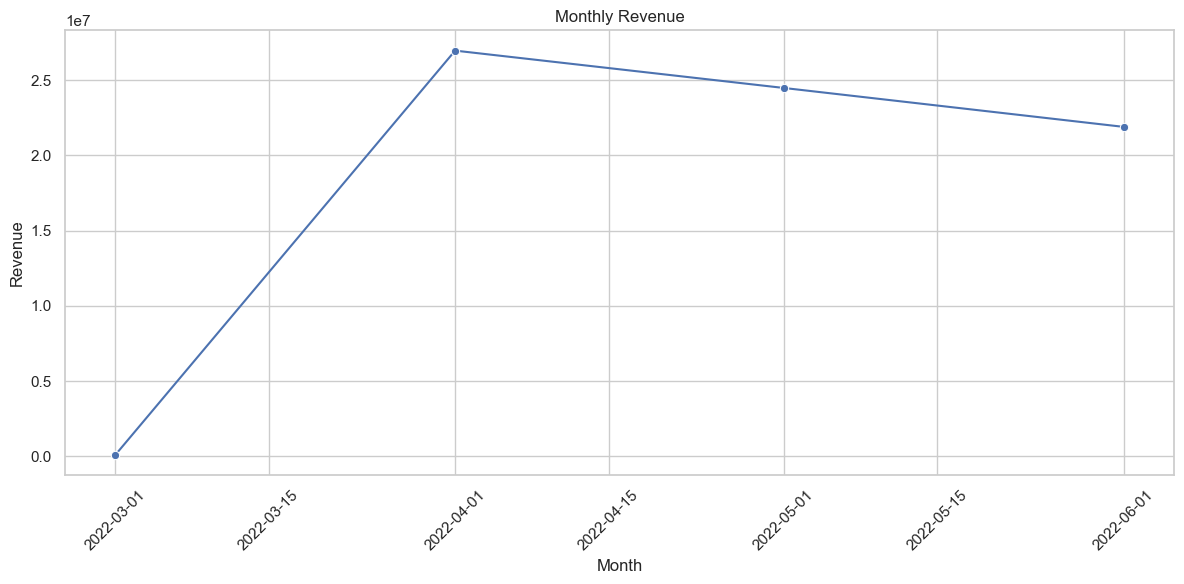

Saved /Users/utkarshbmathur/Blend_All_Projects/assignment_outputs/region_revenue.png


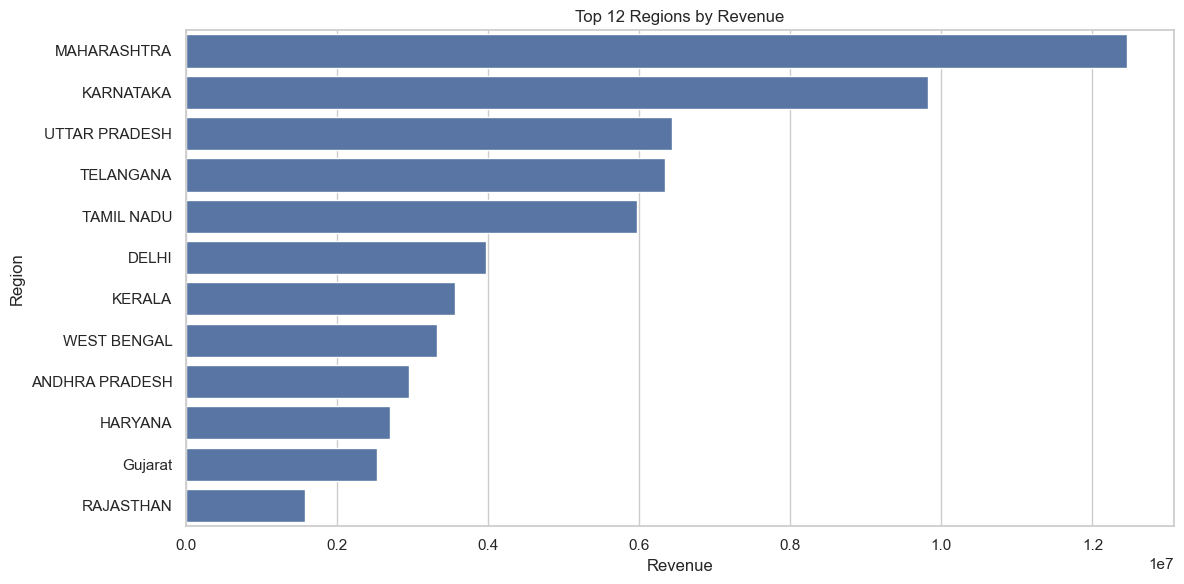

Saved /Users/utkarshbmathur/Blend_All_Projects/assignment_outputs/sales_scatter.png


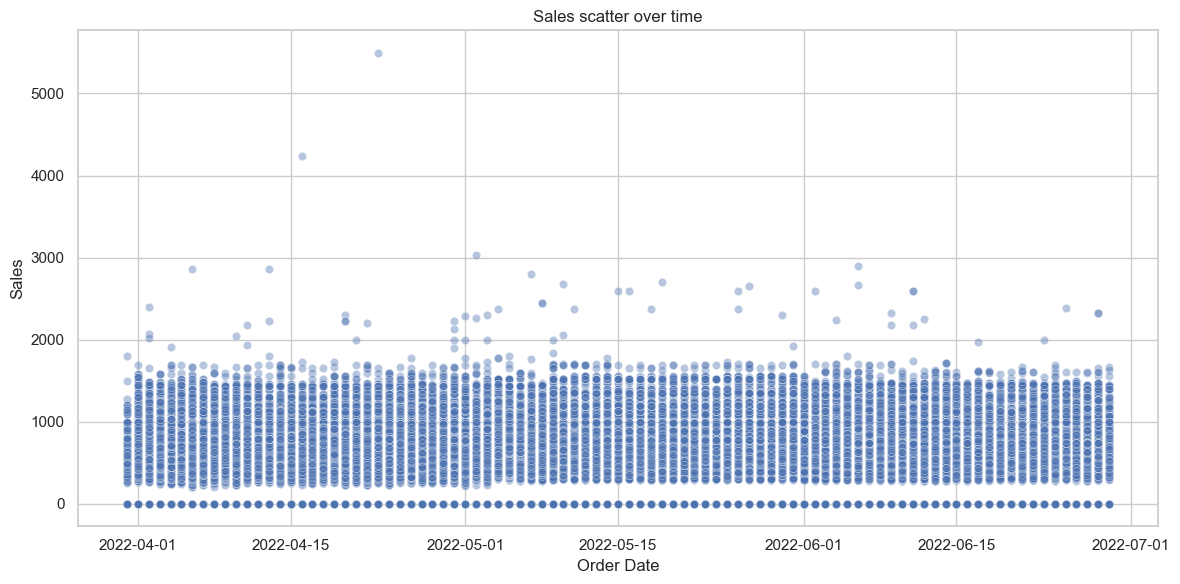


--- Cleaned data preview ---


,index,order_id,order_date,status,fulfilment,sales_channel,ship_service_level,style,sku,category,...,currency,sales,ship_city,ship_state,ship_postal_code,ship_country,promotion_ids,b2b,unnamed:_22,outlier_sales
0,0,405-8078784-5731545,2022-04-30,Cancelled,Merchant,Amazon.in,Standard,SET389,SET389-KR-NP-S,Set,...,INR,647.62,MUMBAI,MAHARASHTRA,400081.0,IN,NaN,False,NaN,False
1,1,171-9198151-1101146,2022-04-30,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,JNE3781,JNE3781-KR-XXXL,kurta,...,INR,406.00,BENGALURU,KARNATAKA,560085.0,IN,Amazon PLCC Free-Financing Universal Merchant ...,False,NaN,False
2,2,404-0687676-7273146,2022-04-30,Shipped,Amazon,Amazon.in,Expedited,JNE3371,JNE3371-KR-XL,kurta,...,INR,329.00,NAVI MUMBAI,MAHARASHTRA,410210.0,IN,IN Core Free Shipping 2015/04/08 23-48-5-108,True,NaN,False
3,3,403-9615377-8133951,2022-04-30,Cancelled,Merchant,Amazon.in,Standard,J0341,J0341-DR-L,Western Dress,...,INR,753.33,PUDUCHERRY,PUDUCHERRY,605008.0,IN,NaN,False,NaN,False
4,4,407-1069790-7240320,2022-04-30,Shipped,Amazon,Amazon.in,Expedited,JNE3671,JNE3671-TU-XXXL,Top,...,INR,574.00,CHENNAI,TAMIL NADU,600073.0,IN,NaN,False,NaN,False
5,5,404-1490984-4578765,2022-04-30,Shipped,Amazon,Amazon.in,Expedited,SET264,SET264-KR-NP-XL,Set,...,INR,824.00,GHAZIABAD,UTTAR PRADESH,201102.0,IN,IN Core Free Shipping 2015/04/08 23-48-5-108,False,NaN,False
6,6,408-5748499-6859555,2022-04-30,Shipped,Amazon,Amazon.in,Expedited,J0095,J0095-SET-L,Set,...,INR,653.00,CHANDIGARH,CHANDIGARH,160036.0,IN,IN Core Free Shipping 2015/04/08 23-48-5-108,False,NaN,False
7,7,406-7807733-3785945,2022-04-30,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,JNE3405,JNE3405-KR-S,kurta,...,INR,399.00,HYDERABAD,TELANGANA,500032.0,IN,Amazon PLCC Free-Financing Universal Merchant ...,False,NaN,False



Files saved in: /Users/utkarshbmathur/Blend_All_Projects/assignment_outputs


In [5]:
# Cell 3 - Run analyzer & produce outputs
an = SalesAnalyzer(csv_path)

print("\n--- Initial preview ---")
an.preview(5)

# Run full cleaning pipeline and compute KPIs
cleaned_csv = out_dir / "cleaned_amazon_sales.csv"
kpis, cleaned_file = an.run_all(str(cleaned_csv))

print("\n--- KPIs ---")
for kk, vv in kpis.items():
    print(f"{kk}: {vv}")

# Plots (saved to out_dir)
p1 = out_dir / "monthly_revenue.png"
p2 = out_dir / "region_revenue.png"
p3 = out_dir / "sales_scatter.png"

an.plot_monthly_revenue(save_path=str(p1))
an.plot_region_sales(top_n=12, save_path=str(p2))
an.plot_sales_scatter(save_path=str(p3))

# Show cleaned data head
print("\n--- Cleaned data preview ---")
display(an.df.head(8))

print("\nFiles saved in:", out_dir)


In [9]:
# Cell 4 — Write .py script without using inspect.getsource()

script_path = out_dir / "sales_analyzer_script.py"

sales_analyzer_code = r"""
#!/usr/bin/env python3
# ----------------------------------------------
# SalesAnalyzer Class - Standalone Script
# ----------------------------------------------

import sys
import os
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime
import matplotlib
matplotlib.use('Agg')  # for headless use
import matplotlib.pyplot as plt
import seaborn as sns

class SalesAnalyzer:
    def __init__(self, path):
        self.path = path
        self.df = pd.read_csv(path, low_memory=False)
        self.kpis = {}
        self.standardize_columns()

    def standardize_columns(self):
        def norm(c):
            c = str(c).strip().lower().replace(" ", "_")
            c = c.replace("(", "").replace(")", "").replace("-", "_")
            return c
        self.df.columns = [norm(c) for c in self.df.columns]

    def find_col(self, candidates):
        for cand in candidates:
            if cand in self.df.columns:
                return cand
        for cand in candidates:
            for c in self.df.columns:
                if cand in c:
                    return c
        return None

    def convert_dates(self):
        col = self.find_col(["order_date", "date", "orderdate"])
        if col:
            try:
                self.df[col] = pd.to_datetime(self.df[col], errors="coerce")
            except:
                self.df[col] = pd.to_datetime(self.df[col], errors="coerce", dayfirst=True)
            if col != "order_date":
                self.df.rename(columns={col: "order_date"}, inplace=True)

    def convert_numerics(self):
        def clean(col):
            self.df[col] = (
                self.df[col].astype(str)
                .str.replace(r"[^0-9\.\-]", "", regex=True)
                .replace("", np.nan)
                .astype(float)
            )

        qty = self.find_col(["quantity", "qty"])
        price = self.find_col(["unit_price", "price"])
        sales = self.find_col(["sales", "amount", "total"])
        profit = self.find_col(["profit"])

        for col in [qty, price, sales, profit]:
            if col:
                clean(col)

        if sales and sales != "sales":
            self.df.rename(columns={sales: "sales"}, inplace=True)

        if qty and qty != "quantity":
            self.df.rename(columns={qty: "quantity"}, inplace=True)

        if price and price != "unit_price":
            self.df.rename(columns={price: "unit_price"}, inplace=True)

        if profit and profit != "profit":
            self.df.rename(columns={profit: "profit"}, inplace=True)

        if "sales" not in self.df.columns and "quantity" in self.df.columns and "unit_price" in self.df.columns:
            self.df["sales"] = self.df["quantity"] * self.df["unit_price"]

    def clean_data(self):
        self.convert_dates()
        self.convert_numerics()
        self.df.drop_duplicates(inplace=True)
        self.df.fillna(0, inplace=True)

    def compute_kpis(self):
        k = {}
        k["total_revenue"] = self.df["sales"].sum()
        k["total_profit"] = self.df["profit"].sum() if "profit" in self.df.columns else np.nan
        k["avg_order_value"] = k["total_revenue"] / len(self.df)
        k["profit_margin_pct"] = 100 * (k["total_profit"] / k["total_revenue"]) if k["total_revenue"] else np.nan
        k["avg_units_per_order"] = self.df["quantity"].mean() if "quantity" in self.df.columns else np.nan
        self.kpis = k
        return k

    def monthly_revenue(self):
        if "order_date" not in self.df.columns:
            return pd.Series()
        tmp = self.df.copy()
        tmp["month"] = tmp["order_date"].dt.to_period("M").dt.to_timestamp()
        return tmp.groupby("month")["sales"].sum()

    def region_sales(self):
        region_col = self.find_col(["region", "state"])
        if not region_col:
            return pd.Series()
        return self.df.groupby(region_col)["sales"].sum().sort_values(ascending=False)

    def plot_monthly_revenue(self, outpath):
        mr = self.monthly_revenue()
        if mr.empty:
            return
        plt.figure()
        sns.lineplot(x=mr.index, y=mr.values, marker="o")
        plt.title("Monthly Revenue")
        plt.savefig(outpath, bbox_inches="tight")
        plt.close()

    def plot_region_sales(self, outpath):
        rs = self.region_sales()
        if rs.empty:
            return
        plt.figure()
        sns.barplot(x=rs.values, y=rs.index)
        plt.title("Region-wise Revenue")
        plt.savefig(outpath, bbox_inches="tight")
        plt.close()

    def run_all(self, outdir):
        os.makedirs(outdir, exist_ok=True)
        self.clean_data()
        self.compute_kpis()
        cleaned = os.path.join(outdir, "cleaned_sales.csv")
        self.df.to_csv(cleaned, index=False)
        self.plot_monthly_revenue(os.path.join(outdir, "monthly_revenue.png"))
        self.plot_region_sales(os.path.join(outdir, "region_revenue.png"))
        return cleaned

if __name__ == "__main__":
    if len(sys.argv) < 3:
        print("Usage: python sales_analyzer_script.py input.csv output_folder")
        sys.exit(1)

    input_csv = sys.argv[1]
    output_dir = sys.argv[2]

    an = SalesAnalyzer(input_csv)
    an.run_all(output_dir)
    print("Done. Output folder:", output_dir)
"""

# Write script file
script_path.write_text(sales_analyzer_code)

print("sales_analyzer_script.py created at:", script_path)


sales_analyzer_script.py created at: /Users/utkarshbmathur/Blend_All_Projects/assignment_outputs/sales_analyzer_script.py


In [11]:
# Cell 5 - package cleaned CSV, script, and plots into zip for submission
zip_path = out_dir / "assignment_submission.zip"
with zipfile.ZipFile(zip_path, 'w', compression=zipfile.ZIP_DEFLATED) as zf:
    # add cleaned csv
    zf.write(out_dir / "cleaned_amazon_sales.csv", arcname="cleaned_amazon_sales.csv")
    # add script
    zf.write(out_dir / "sales_analyzer_script.py", arcname="sales_analyzer_script.py")
    # add plots if exist
    for fname in ["monthly_revenue.png", "region_revenue.png", "sales_scatter.png"]:
        p = out_dir / fname
        if p.exists():
            zf.write(p, arcname=fname)
    # optionally include README (next cell will create it)
print("Created zip:", zip_path)


Created zip: /Users/utkarshbmathur/Blend_All_Projects/assignment_outputs/assignment_submission.zip


In [13]:
# Cell 6 - README for submission (edit as needed)
readme_text = f"""
Assignment: eRetail Sales Data Cleaning & Exploratory Analysis
Submitted by: <Your Name>

Files included:
1) cleaned_amazon_sales.csv         - cleaned dataset used for analysis
2) sales_analyzer_script.py         - runnable script to reproduce results
3) monthly_revenue.png              - plot of monthly revenue
4) region_revenue.png               - top regions by revenue
5) sales_scatter.png                - sales over time scatter plot
6) assignment_submission.zip        - zip with all above files
7) this_notebook.ipynb              - original Jupyter notebook (include when submitting)
8) README.txt                       - this file

How to run (locally):
- Open the notebook and run all cells, OR:
- From terminal:
    python sales_analyzer_script.py "/path/to/Amazon Sale Report(in).csv" "/path/to/output_dir"

Screenshots to include in submission:
- Cleaned data preview: first 8 rows after cleaning (cell output)
- KPIs printed (cell output)
- Each plot (png files above)

Notes:
- I standardized column names to lowercase and underscores.
- If the date column didn't parse correctly, I attempted both month-first and day-first formats.
- If any expected columns (sales, quantity, profit) are missing, the script attempts to compute sales from quantity * unit_price when possible.

"""
(readme_path := out_dir / "README.txt").write_text(readme_text)
# Also add README to the zip
with zipfile.ZipFile(out_dir / "assignment_submission.zip", 'a', compression=zipfile.ZIP_DEFLATED) as zf:
    zf.write(readme_path, arcname="README.txt")
print("Wrote README to", readme_path)


Wrote README to /Users/utkarshbmathur/Blend_All_Projects/assignment_outputs/README.txt
